In [47]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft
from spectrum import *

In [48]:
from nt_toolbox.general import *
from nt_toolbox.signal import *

In [28]:
def show_image(title, img):
    plt.figure(figsize=(1.121, 1.5), dpi=1000)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.savefig(title + ".png", dpi=1000)
    plt.show()

In [29]:
def show_plot(title, x, y):
    plt.figure(title, figsize=(4, 3), dpi=100)
    plt.title(title)
    plt.plot(x, y)
    plt.savefig(title + ".png", dpi=100)
    plt.show()

In [30]:
def get_snr_db(img, noise):
    img_power = np.var(img)
    noise_power = np.var(noise)
    return 10*np.log10(img_power / noise_power)

In [31]:
def find_element(l, el):
    ''' find an integer in a list of floats'''
    if not l:
        return None
    
    copy_l = [l[i] - el for i in range(len(l))]
    signal = copy_l[0] > 0
    
    for index in range(len(copy_l)):
        if ((copy_l[index] > 0) == signal):
            continue
        else:
            return index
            
    return None

In [32]:
def gaussian_noise(img, mean, var):
    return np.random.normal(mean, var, img.shape)

In [33]:
def calculate_gaussian_kernel(size=3, sigma=1):
    kernel = np.zeros((size, size))
    for g_i, k_i in zip(range(int(-size/2), int(size/2) + 1), range(0, size)):
        for g_j, k_j in zip(range(int(-size/2), int(size/2)+1), range(0, size)):
            kernel[k_i][k_j] = np.exp(-(g_i*g_i + g_j*g_j)/(2*sigma*sigma))/(2*np.pi*sigma*sigma)
    
    return kernel

In [34]:
def create_gaussian_kernel(size=3, sigma=1):
    h = signal.gaussian(size, sigma).reshape(size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

In [35]:
def wiener_denoise(img, gaussian_kernel, sigma):
    gaussian_kernel /= np.sum(gaussian_kernel)
    copy = np.copy(img)
    copy = np.fft.fft2(copy)
    gaussian_kernel = np.fft.fft2(gaussian_kernel, s = img.shape)
    gaussian_kernel = np.conj(gaussian_kernel / np.abs(gaussian_kernel) ** 2 + sigma)
    copy = copy * gaussian_kernel
    copy = np.abs(np.fft.ifft2(copy))
    return copy

In [36]:
barb = cv2.imread("barbara.jpg", 0)

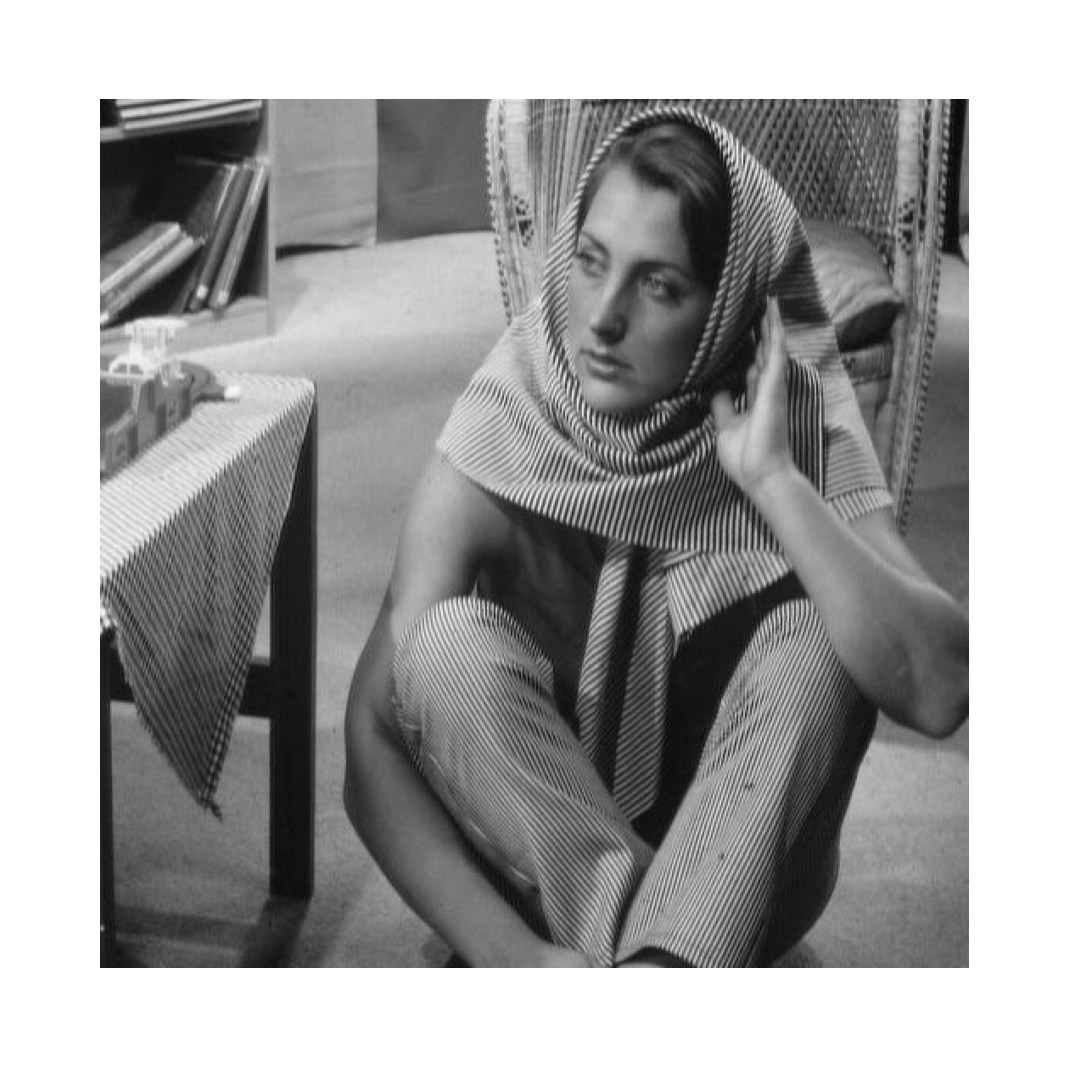

In [37]:
show_image("hey-barb", barb)

In [38]:
x_axis = [sigma for sigma in np.arange(0.001, 60.001, 0.01)]

In [39]:
snr_db_data = [get_snr_db(barb, gaussian_noise(barb, 0, sigma)) for sigma in x_axis]

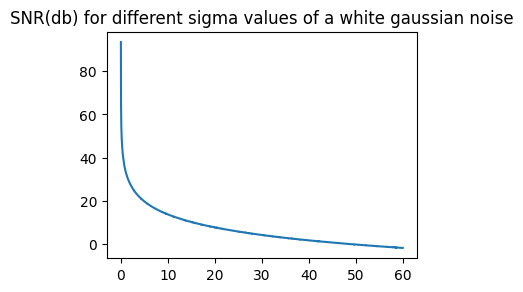

In [40]:
show_plot("SNR(db) for different sigma values of a white gaussian noise", x_axis, snr_db_data)

In [41]:
# barb sigma, 0 db
print(np.sqrt(np.var(barb)))

47.828561537051804


In [42]:
db_vals = [0.0, 5.0, 10.0, 15.0, 20.0]

In [43]:
x_vals = [find_element(snr_db_data, db) for db in db_vals]

In [44]:
sigma_vals = [x_axis[i] for i in x_vals]

In [45]:
print(sigma_vals)

[47.82099999999999, 26.880999999999997, 15.120999999999997, 8.490999999999998, 4.771]


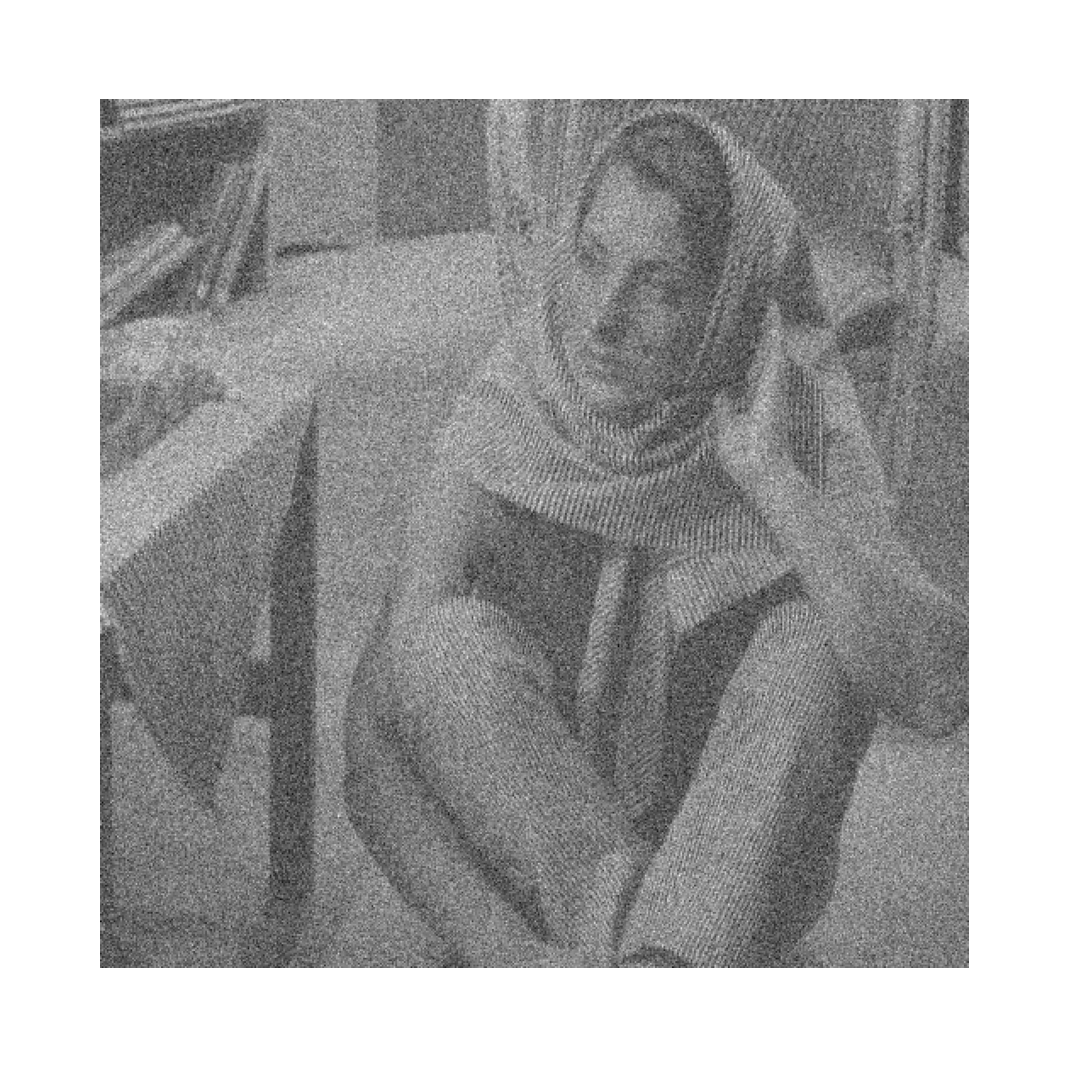

TypeError: cconv() missing 1 required positional argument: 'd'

In [49]:
for sigma in sigma_vals:
    noise = gaussian_noise(barb, 0, sigma)
    noisy = barb + noise
    
    show_image("Noisy image with sigma = " + str(sigma), noisy)
    
    N = barb.shape[0] * barb.shape[1]

    # Estimating P the power-spectrum
    P = 1/N * abs(fft(barb)**2)
    
    # Computing the approximate Wiener filter
    #h_w = real(ifft(P / (P + sigma**2)))
    h_w = ifft(P / (P + sigma**2))
    denoise = cconv(barb, h_w)
    
    
    show_image("Denoised image with sigma = " + str(sigma), denoise)